# Issue 564 - error in calling fatray in traveltime manager

This notebook was made on response of a github issue for pyGIMLi.
The full issue can be found on https://github.com/gimli-org/gimli/issues/564

In [1]:
import pygimli as pg
from pygimli.physics import TravelTimeManager
import pygimli.physics.traveltime as tt

In [2]:

data = tt.load("koenigsee.sgt")
data["err"] = 0.001
mgr = tt.TravelTimeManager(data=data, secNodes=4)
if 0:
    mgr.invert(absoluteError=0.001, vTop=300, vBottom=3000, quality=34.4)
    mgr.showResult(cMin=500, cMax=3000, logScale=False, cMap="Spectral_r")
    pg.show(mgr.paraDomain, mgr.fop.jacobian().row(40))

In [4]:
mgr = tt.TravelTimeManager(data=data, fatray=True, secNodes=3, frequency=500.)
mgr.invert(absoluteError=0.001, vTop=300, vBottom=3000)

25/10/23 - 09:26:14 - pyGIMLi - INFO - Found 1 regions.
25/10/23 - 09:26:14 - pyGIMLi - INFO - Found 1 regions.
25/10/23 - 09:26:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/10/23 - 09:26:14 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
25/10/23 - 09:26:14 - pyGIMLi - INFO - Create gradient starting model. 300: 3000
25/10/23 - 09:26:14 - pyGIMLi - INFO - Created startmodel from forward operator: 888, min/max=0.000333/0.003333


888 [1289.8217906624138,...,2680.602548452853]

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x23c4520a5b0>)

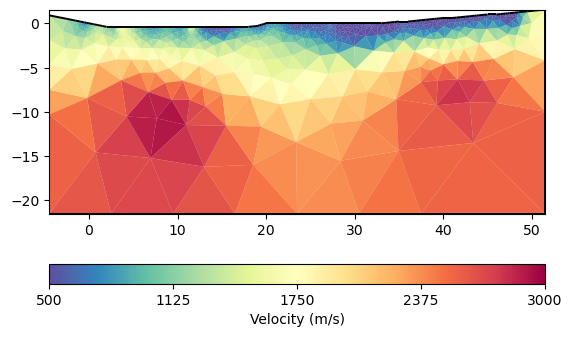

In [5]:
mgr.showResult(cMin=500, cMax=3000, logScale=False, cMap="Spectral_r")

RMatrix: 714 x 888
888 [0.0,...,0.0]


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x23c456e1f40>)

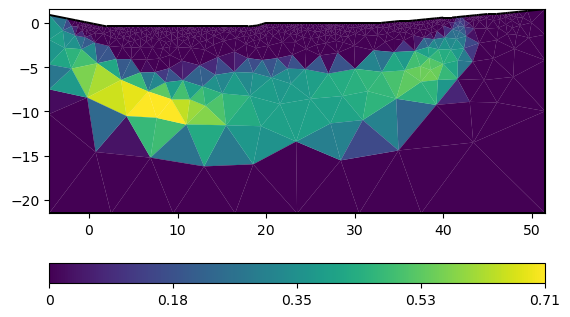

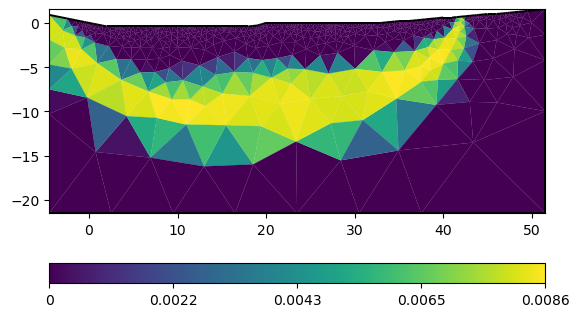

In [6]:
J = mgr.fop.J  # jacobian()
print(J)
j40 = J.row(40)
print(j40)
pg.show(mgr.paraDomain, j40)
pg.show(mgr.paraDomain, mgr.fop.FresnelWeight[40])

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x23c46b5eee0>)

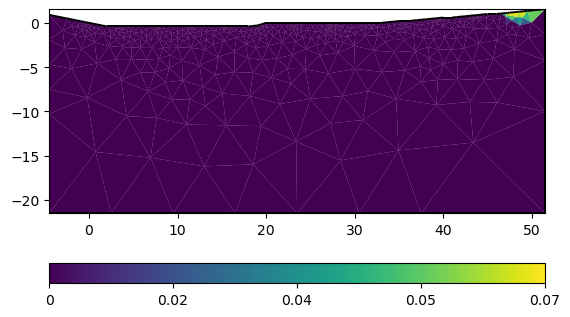

In [8]:
import numpy as np
self = mgr.fop
# mesh = self.mesh()
mesh = self.meshNoSec
slowness = pg.Vector(mesh.cellCount(), 0.001)
self.J = pg.Matrix(self.data.size(), mesh.cellCount())
self.sensorNodes = [mesh.findNearestNode(pos)
                    for pos in self.data.sensorPositions()]
if (self.iMat.cols() != mesh.nodeCount() or
        self.iMat.rows() != mesh.cellCount()):
    self.iMat = mesh.interpolationMatrix(mesh.cellCenters())

Di = self.dijkstra
slowPerCell = self.createMappedModel(slowness, 1e16)
Di.setGraph(self._core.createGraph(slowPerCell))
numN = mesh.nodeCount()
data = self.data
numS = data.sensorCount()
Tmat = pg.Matrix(numS, numN)
Dmat = pg.Matrix(numS, numS)
for i, node in enumerate(self.sensorNodes):
    Di.setStartNode(node)
    Tmat[i] = Di.distances()[:numN]
    Dmat[i] = Tmat[i][self.sensorNodes]

for i in range(data.size()):
    iS = int(data("s")[i])
    iG = int(data("g")[i])
    tsr = Dmat[iS][iG]  # shot-receiver travel time
    dt = self.iMat * (Tmat[iS] + Tmat[iG]) - tsr
    weight = np.maximum(1 - 2 * self.frequency * dt, 0.0)  # 1 on ray
    wa = weight  # * np.sqrt(self.mesh().cellSizes())
    if np.sum(wa) > 0:  # not if all values are zero
        wa /= np.sum(wa)

    self.J[i] = wa * tsr / slowness
pg.show(mesh, weight)#self.J.row(40))